In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# データの読み込み

In [2]:
d = load_iris()

In [3]:
x = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.DataFrame(d['target'], columns=['y_target'])

df = pd.concat([x, y], axis=1)
df.loc[:, 'target'] = df['y_target'].map({idx:t for idx, t in enumerate(d['target_names'])})
df = pd.concat([df, pd.get_dummies(df['y_target'], prefix='y_target')], axis=1)

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_target,target,y_target_0,y_target_1,y_target_2
0,5.1,3.5,1.4,0.2,0,setosa,1,0,0
1,4.9,3.0,1.4,0.2,0,setosa,1,0,0
2,4.7,3.2,1.3,0.2,0,setosa,1,0,0
3,4.6,3.1,1.5,0.2,0,setosa,1,0,0
4,5.0,3.6,1.4,0.2,0,setosa,1,0,0


# learning curveの図を出す関数

In [61]:
from sklearn.learning_curve import learning_curve


def plot_learning_curve(model, X, y, train_sizes, cv):
    _, train_scores, valid_scores = learning_curve(model, X,
                                                         y, train_sizes=train_sizes, cv=cv)
    
    # cross validationの数毎に出力するのでその平均を取るようにする
    take_means = lambda s: np.mean(s, axis=1)

    _, ax = plt.subplots()
    t = [str(i) for i in train_sizes]
    ax.plot(t, take_means(train_scores), marker='.', markersize=10, label='train')
    ax.plot(t, take_means(valid_scores), famarker='.', markersize=10, label='test')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('訓練データ数')
    ax.set_xticks(t)
    ax.set_xticklabels(t)

    plt.legend()
    plt.show()

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
X = df[['sepal length (cm)']]
y = df['y_target_1']
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=3, random_state=71)

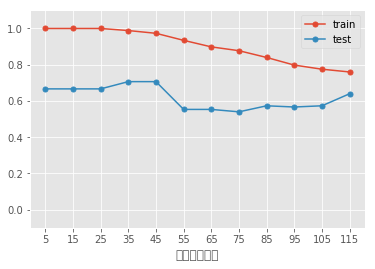

In [64]:
plot_learning_curve(model, X, y, train_sizes=range(5, 120, 10), cv=5)

# 訓練・テストデータをがっちゃんこして確率値までセットする関数

In [66]:
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(df[['sepal length (cm)']], df['y_target_1'], test_size=0.3)

In [108]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=71,
            splitter='best')

In [109]:
proba = model.predict_proba(X_train)

In [118]:
def concat_proba_data(model, target_names, x, y):
    df = pd.concat([x, y], axis=1)
    df.loc[:, 'predicted'] = model.predict(x)
    
    proba = model.predict_proba(x)
    for idx, target_name in enumerate(target_names):
        df.loc[:, 'y_{}'.format(target_name)] = proba[:, idx]

    return df

In [119]:
train_df = concat_proba_data(model, ['yes', 'no'], X_train, y_train)
test_df = concat_proba_data(model, ['yes', 'no'], X_test, y_test)

In [120]:
train_df.head()

,sepal length (cm),y_target_1,predicted,y_yes,y_no
15,5.7,0,1,0.423077,0.576923
137,6.4,0,0,0.703704,0.296296
132,6.4,0,0,0.703704,0.296296
11,4.8,0,0,1.000000,0.000000
87,6.3,1,0,0.703704,0.296296


In [121]:
test_df.head()

,sepal length (cm),y_target_1,predicted,y_yes,y_no
41,4.5,0,0,1.000000,0.000000
71,6.1,1,1,0.423077,0.576923
108,6.7,0,0,0.703704,0.296296
21,5.1,0,0,0.823529,0.176471
4,5.0,0,0,0.823529,0.176471


# 確率値のヒストグラム表示

* 正解、不正解毎に出力

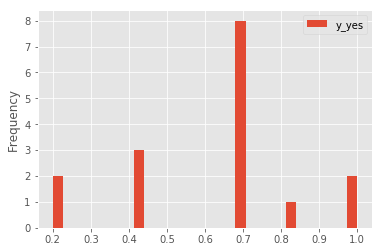

In [124]:
test_df.loc[test_df['y_target_1'] == 1, ['y_yes']].plot.hist(bins=30)

In [126]:
def plot_proba_hist(df, target_name, proba_name, bins=30):
    _, axes = plt.subplots(nrows=2, figsize=(20, 10))
    test_df.loc[test_df[target_name] == test_df['predicted'], [proba_name]].plot.hist(bins=bins, ax=axes[0])
    test_df.loc[test_df[target_name] != test_df['predicted'],, [proba_name]].plot.hist(bins=bins, ax=axes[1])
    
    axes[0].set_xlim(-0.1, 1.1)
    axes[1].set_xlim(-0.1, 1.1)    
    plt.show()

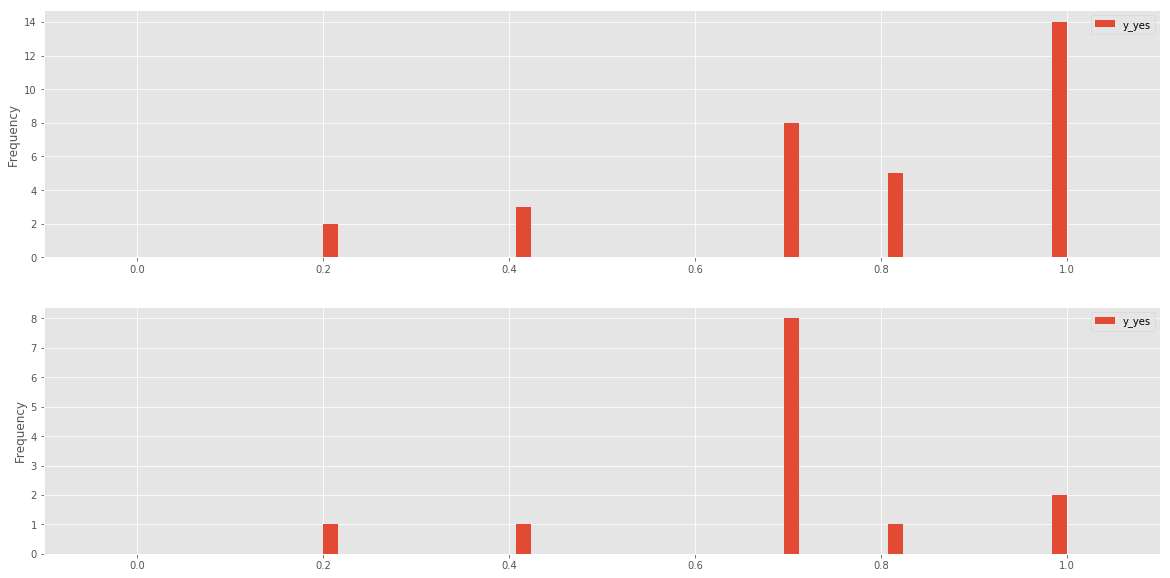

In [130]:
plot_proba_hist(train_df, 'y_target_1', 'y_yes', bins=50)

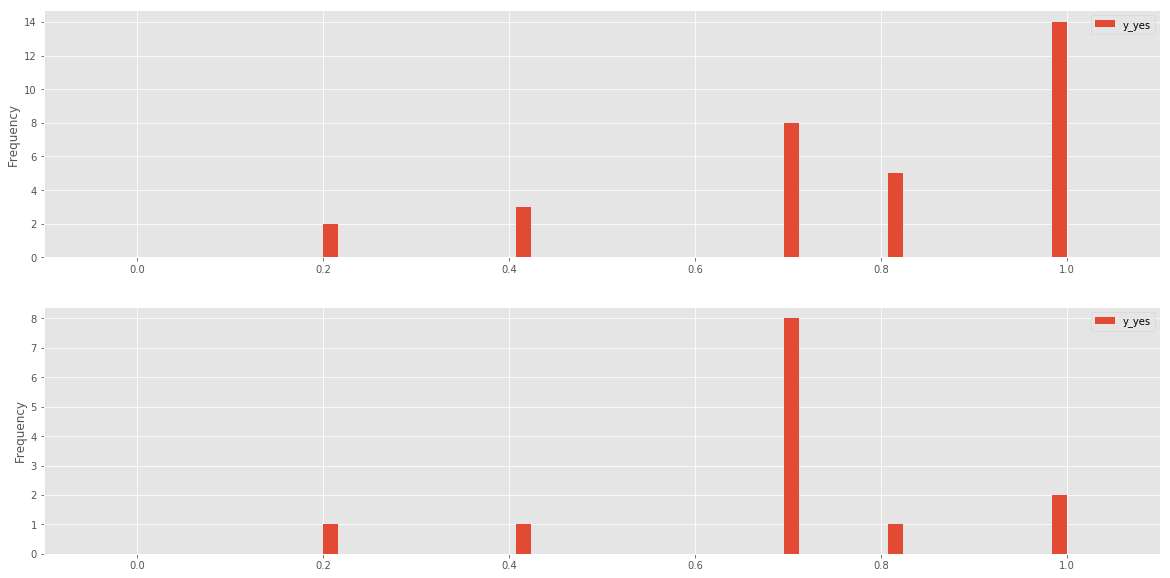

In [132]:
plot_proba_hist(test_df, 'y_target_1', 'y_yes', bins=50)

# AUC値の出力

In [153]:
X_train, X_test, y_train, y_test = train_test_split(df[['sepal length (cm)']], df['y_target'], test_size=0.3)

In [154]:
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=3, random_state=71)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=71,
            splitter='best')

In [162]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [156]:
# Compute macro-average ROC curve and ROC area
n_classes = 3

In [175]:
_y_test = label_binarize(y_test, classes=np.unique(y_train))

In [176]:
_y_test.shape

(45, 3)

In [177]:
y_score.shape

(45, 3)

In [182]:
y_score = model.predict(X_test)
y_score = label_binarize(y_score, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
from scipy import interp

NameError: name 'cycle' is not defined

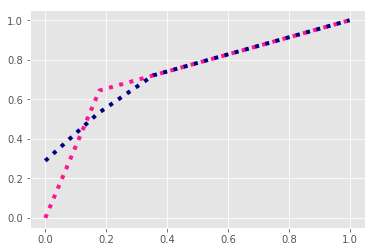

In [185]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()